In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import re
import seaborn as sns
!pip install graphviz
!pip install -U imbalanced-learn

import graphviz
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO
startup_df = pd.read_csv("modelling_df.csv", delimiter=',', header = 0, encoding = "ISO-8859-1",skipinitialspace=True)

startup_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3267 entries, 0 to 3266
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   market                3267 non-null   object 
 1   funding_rounds        3267 non-null   float64
 2   founded_month         3267 non-null   float64
 3   founded_year          3267 non-null   float64
 4   seed                  3267 non-null   float64
 5   venture               3267 non-null   float64
 6   equity_crowdfunding   3267 non-null   float64
 7   undisclosed           3267 non-null   float64
 8   convertible_note      3267 non-null   float64
 9   debt_financing        3267 non-null   float64
 10  angel                 3267 non-null   float64
 11  grant                 3267 non-null   float64
 12  private_equity        3267 non-null   float64
 13  secondary_market      3267 non-null   float64
 14  product_crowdfunding  3267 non-null   float64
 15  round_A              

# ADABoost

Results:
Number of Estimators: 50, ROC-AUC: 0.7033750281721884
Number of Estimators: 100, ROC-AUC: 0.698867478025693
Number of Estimators: 150, ROC-AUC: 0.6974306964164977
Number of Estimators: 200, ROC-AUC: 0.6869788145143115


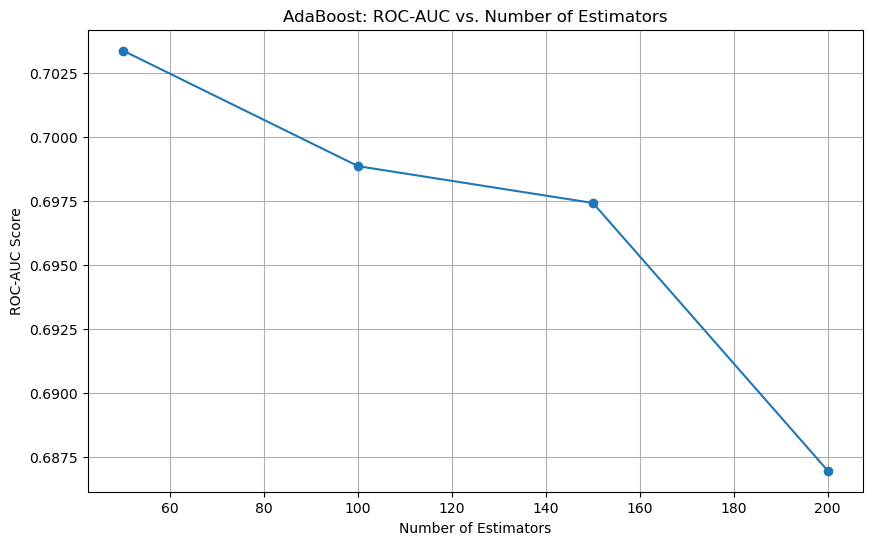

In [2]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


X = pd.get_dummies(startup_df.drop(['status_binary'], axis=1))
y = startup_df['status_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of different numbers of estimators to test
n_estimators_values = [50, 100, 150, 200]

# Create an empty dictionary to store results
results = {}

# Loop over different numbers of estimators
for n_estimators in n_estimators_values:
    # Initialize and train the AdaBoost classifier
    ada_model = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
    ada_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = ada_model.predict(X_test)
    
    # Calculate and store the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    results[n_estimators] = roc_auc

# Display or plot the results
print("Results:")
for n_estimators, roc_auc in results.items():
    print(f"Number of Estimators: {n_estimators}, ROC-AUC: {roc_auc}")

# Plot the results if desired
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.title('AdaBoost: ROC-AUC vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('ROC-AUC Score')
plt.grid(True)
plt.show()


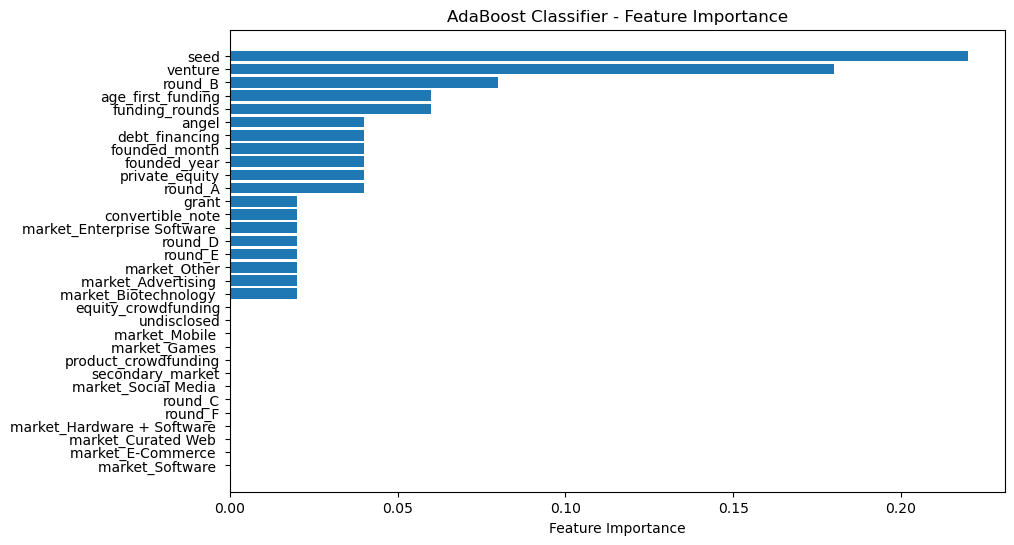

In [3]:
# Train AdaBoostClassifier
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# Plot feature importance
feature_importance = ada_model.feature_importances_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('AdaBoost Classifier - Feature Importance')
plt.show()


C:\Users\aa3-adebayo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


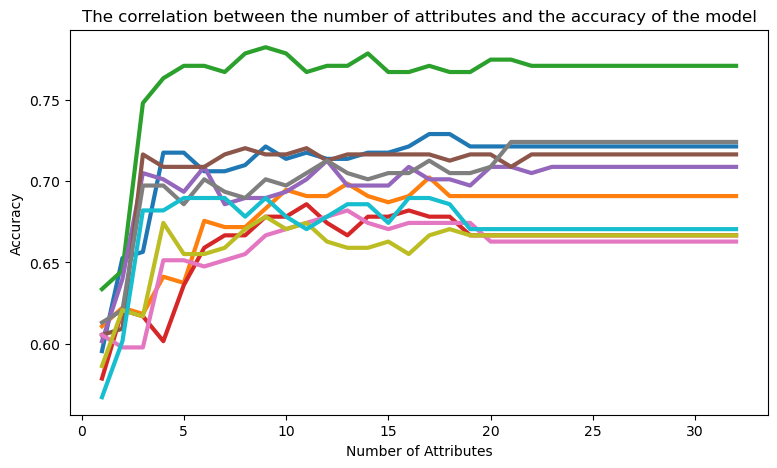

Feature Importances:
venture                        0.045201
funding_rounds                 0.033501
seed                           0.033272
age_first_funding              0.020978
debt_financing                 0.007678
founded_year                   0.005804
market_Biotechnology           0.003519
round_B                        0.003336
round_D                        0.002879
convertible_note               0.002742
private_equity                 0.002559
angel                          0.002148
market_Enterprise Software     0.001600
market_Advertising             0.001554
round_E                        0.001325
round_A                        0.000823
founded_month                  0.000000
dtype: float64


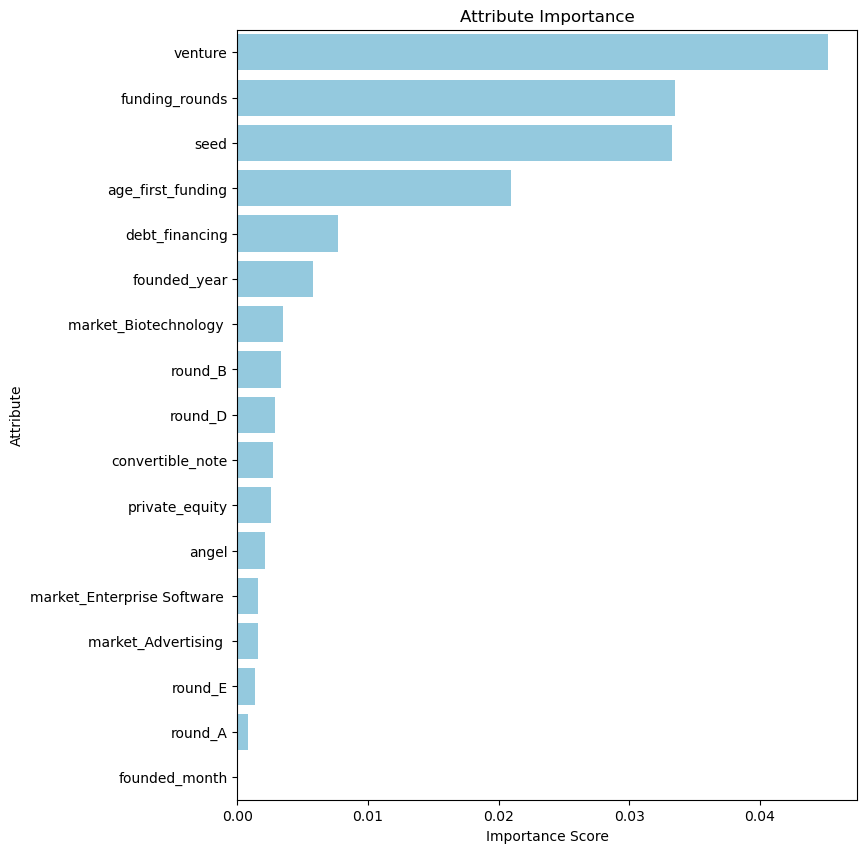

In [4]:
 #Initialize AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_train, y_train)

# Plot the correlation between the number of attributes and the accuracy of the model
plt.figure(figsize=(9, 5))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)
plt.title('The correlation between the number of attributes and the accuracy of the model')
plt.xlabel('Number of Attributes')
plt.ylabel('Accuracy')
plt.show()

# Select features using Recursive Feature Elimination with Cross-Validation (RFECV)
selected_features = X_train.columns[rfecv.support_]

# Drop non-selected features from the feature matrix X
X_selected = X[selected_features]

# Split the data into training and testing sets using the selected features
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=42)

# Fit the AdaBoost model using the training data with selected features
model.fit(X_train_selected, y_train)

# Evaluate feature importance using permutation importance
result = permutation_importance(model, X_train_selected, y_train, n_repeats=10, random_state=0)

# Create a Series of feature importances sorted in descending order
feature_importances = pd.Series(result.importances_mean, index=X_train_selected.columns.values).sort_values(ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importances)

# Create a horizontal bar plot using seaborn
plt.figure(figsize=(8, 10))
sns.barplot(x=feature_importances.values, y=feature_importances.index, color='skyblue')

# Set labels for the x-axis and y-axis
plt.xlabel('Importance Score')
plt.ylabel('Attribute')

# Set the title of the plot
plt.title('Attribute Importance')

# Display the plot
plt.show()

AUC: 0.764


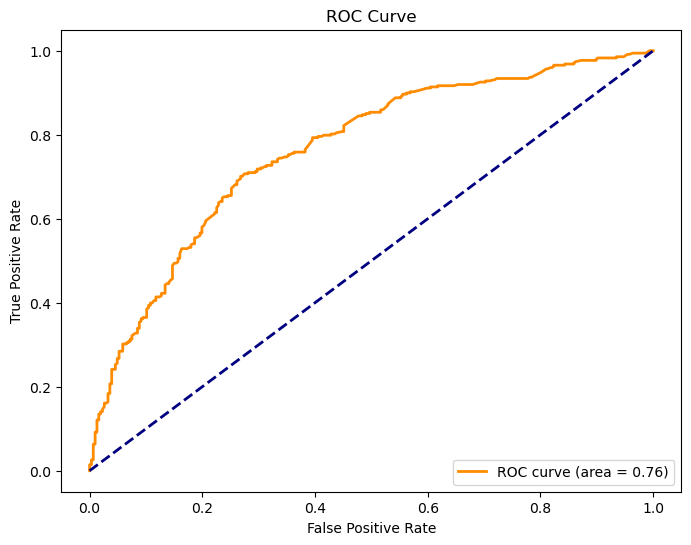

In [5]:
# Predict probabilities for the positive class
y_prob = ada_model.predict_proba(X_test)[:, 1]

# Ensure y_test and y_prob have the same indices
y_test = y_test[X_test.index]

# Calculate AUC
auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc:.3f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')


plt.show()



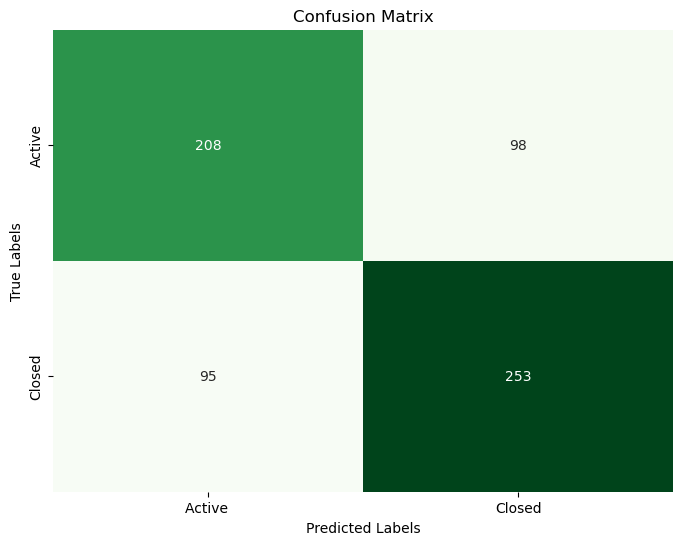


Classification Report:
               precision    recall  f1-score   support

           0      0.686     0.680     0.683       306
           1      0.721     0.727     0.724       348

    accuracy                          0.705       654
   macro avg      0.704     0.703     0.703       654
weighted avg      0.705     0.705     0.705       654



In [9]:
# Generate confusion matrix
y_pred = ada_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Active ', 'Closed'], yticklabels=['Active', 'Closed'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
classification_report_result = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:\n", classification_report_result)


In [7]:
#Additional Steps (1 to 5)
# Step 1: Make predictions on a random sample from the test set
random_sample = X_test.sample(n=1)
single_prediction = ada_model.predict(random_sample)

# Step 2: Display the prediction and associated confidence
print('\nStep 1: Make predictions on a random sample from the test set')
print('Predicted Class:', single_prediction[0])

if single_prediction == 1:
    print(f'This startup is predicted to be successful with confidence.')
    display(random_sample)
elif single_prediction == 0:
    print(f'This startup is predicted NOT to be successful with confidence.')
    display(random_sample)


Step 1: Make predictions on a random sample from the test set
Predicted Class: 1
This startup is predicted to be successful with confidence.


,funding_rounds,founded_month,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,...,market_Biotechnology,market_Curated Web,market_E-Commerce,market_Enterprise Software,market_Games,market_Hardware + Software,market_Mobile,market_Other,market_Social Media,market_Software
2912,4.0,1.0,2009.0,0.0,12444994.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


# With SMOTE

Results:
Number of Estimators: 50, ROC-AUC: 0.7194613477574938
Number of Estimators: 100, ROC-AUC: 0.719658553076403
Number of Estimators: 150, ROC-AUC: 0.7037130944331755
Number of Estimators: 200, ROC-AUC: 0.7012339418526031


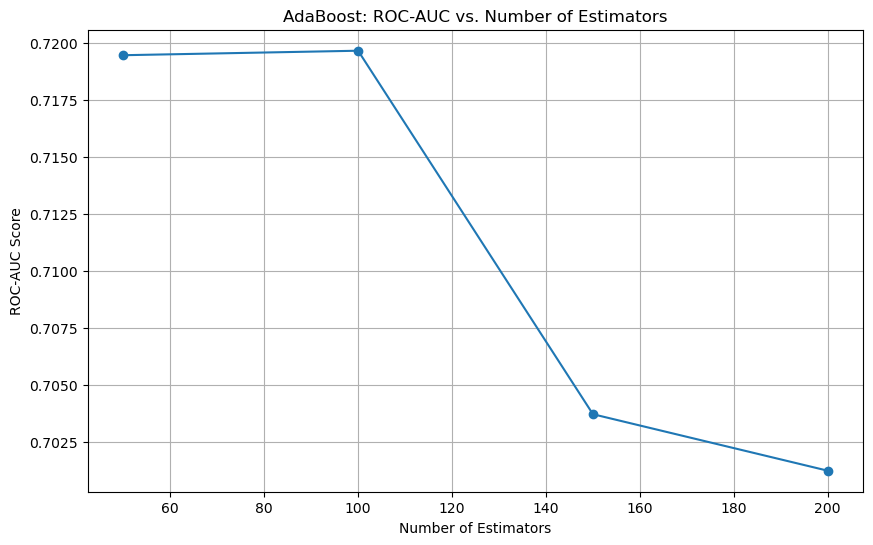

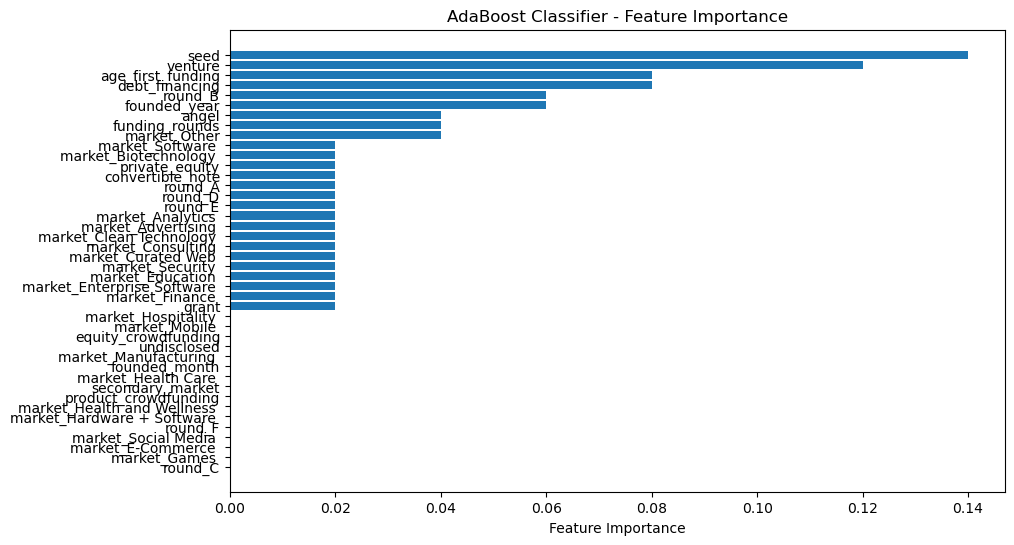

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
startup_df = pd.read_csv("modelling_df.csv", delimiter=',', header=0, encoding="ISO-8859-1", skipinitialspace=True)

# Data Preparation
X = pd.get_dummies(startup_df.drop(['status_binary'], axis=1))
y = startup_df['status_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define a list of different numbers of estimators to test
n_estimators_values = [50, 100, 150, 200]

# Create an empty dictionary to store results
results = {}

# Loop over different numbers of estimators
for n_estimators in n_estimators_values:
    # Initialize and train the AdaBoost classifier
    ada_model = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
    ada_model.fit(X_train_smote, y_train_smote)
    
    # Make predictions on the test set
    y_pred = ada_model.predict(X_test)
    
    # Calculate and store the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    results[n_estimators] = roc_auc

# Display or plot the results
print("Results:")
for n_estimators, roc_auc in results.items():
    print(f"Number of Estimators: {n_estimators}, ROC-AUC: {roc_auc}")

# Plot the results if desired
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.title('AdaBoost: ROC-AUC vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('ROC-AUC Score')
plt.grid(True)
plt.show()

# Train AdaBoostClassifier with SMOTE
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model.fit(X_train_smote, y_train_smote)

# Plot feature importance
feature_importance = ada_model.feature_importances_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(X_train_smote.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_train_smote.shape[1]), X_train_smote.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('AdaBoost Classifier - Feature Importance')
plt.show()



C:\Users\aa3-adebayo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


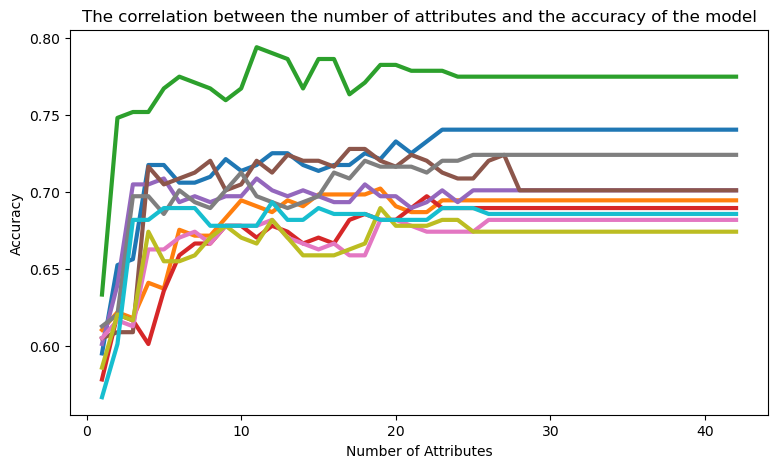

Feature Importances:
venture                        0.074177
seed                           0.035420
funding_rounds                 0.029433
age_first_funding              0.016179
founded_year                   0.007358
debt_financing                 0.006901
market_Clean Technology        0.004845
round_D                        0.003611
grant                          0.003108
market_Finance                 0.002834
market_Biotechnology           0.002742
private_equity                 0.002651
market_Consulting              0.002605
convertible_note               0.002194
round_E                        0.001371
market_Other                   0.001188
market_Enterprise Software     0.001097
angel                          0.000823
round_B                        0.000777
market_Analytics               0.000731
round_A                        0.000183
market_Education               0.000000
undisclosed                    0.000000
market_Hardware + Software     0.000000
market_Mobile      

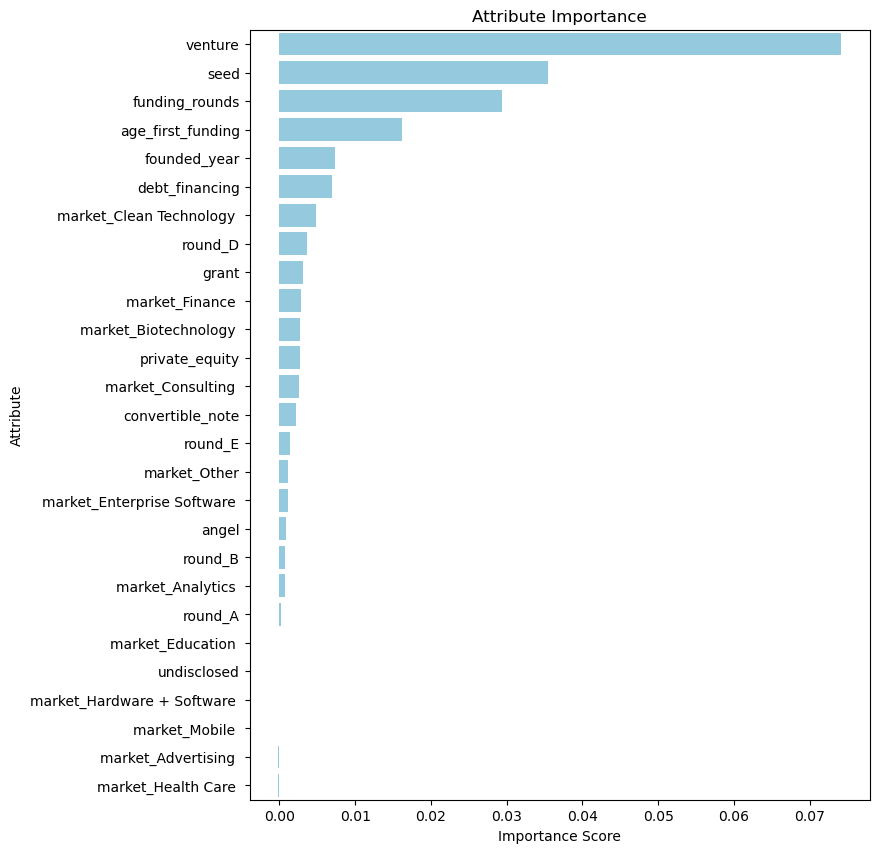

In [3]:
from sklearn.model_selection import StratifiedKFold  # Import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance

model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_train, y_train)

# Plot the correlation between the number of attributes and the accuracy of the model
plt.figure(figsize=(9, 5))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)
plt.title('The correlation between the number of attributes and the accuracy of the model')
plt.xlabel('Number of Attributes')
plt.ylabel('Accuracy')
plt.show()

# Select features using Recursive Feature Elimination with Cross-Validation (RFECV)
selected_features = X_train.columns[rfecv.support_]

# Drop non-selected features from the feature matrix X
X_selected = X[selected_features]

# Split the data into training and testing sets using the selected features
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=42)

# Fit the AdaBoost model using the training data with selected features
model.fit(X_train_selected, y_train)

# Evaluate feature importance using permutation importance
result = permutation_importance(model, X_train_selected, y_train, n_repeats=10, random_state=0)

# Create a Series of feature importances sorted in descending order
feature_importances = pd.Series(result.importances_mean, index=X_train_selected.columns.values).sort_values(ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importances)

# Create a horizontal bar plot using seaborn
plt.figure(figsize=(8, 10))
sns.barplot(x=feature_importances.values, y=feature_importances.index, color='skyblue')

# Set labels for the x-axis and y-axis
plt.xlabel('Importance Score')
plt.ylabel('Attribute')

# Set the title of the plot
plt.title('Attribute Importance')

# Display the plot
plt.show()

AUC: 0.763


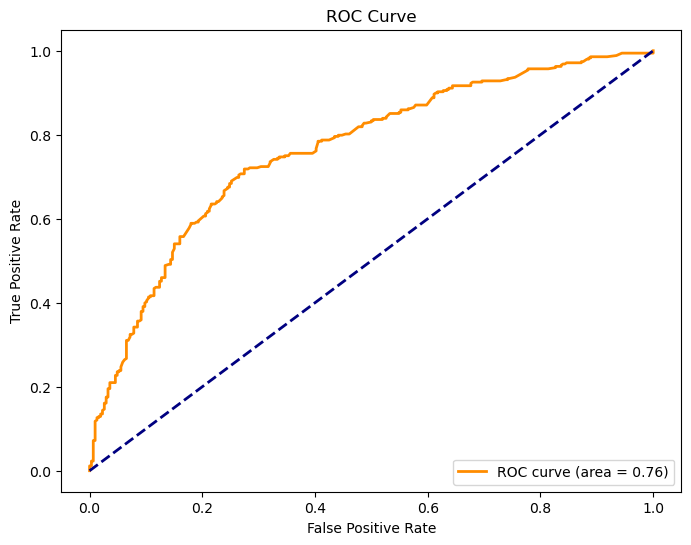

In [4]:

# Predict probabilities for the positive class
y_prob = ada_model.predict_proba(X_test)[:, 1]

# Ensure y_test and y_prob have the same indices
y_test = y_test[X_test.index]

# Calculate AUC
auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc:.3f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

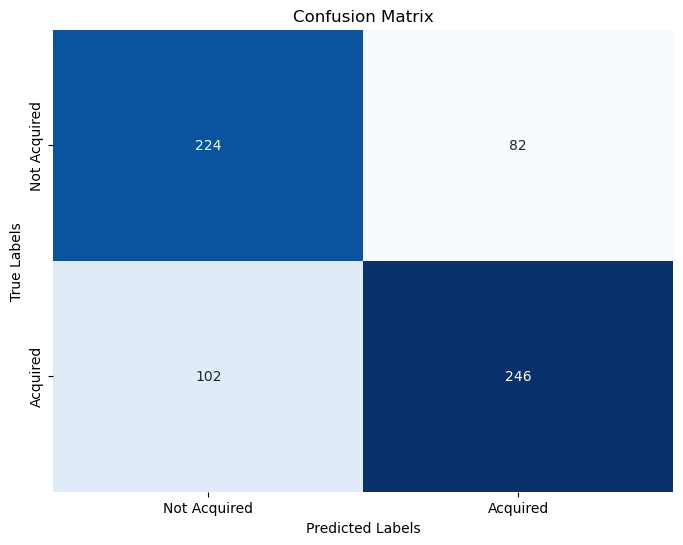


Classification Report:
               precision    recall  f1-score   support

           0      0.687     0.732     0.709       306
           1      0.750     0.707     0.728       348

    accuracy                          0.719       654
   macro avg      0.719     0.719     0.718       654
weighted avg      0.721     0.719     0.719       654



In [5]:
# Generate confusion matrix
y_pred = ada_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Acquired', 'Acquired'], yticklabels=['Not Acquired', 'Acquired'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
classification_report_result = classification_report(y_test, y_pred, digits=3)
print("\nClassification Report:\n", classification_report_result)

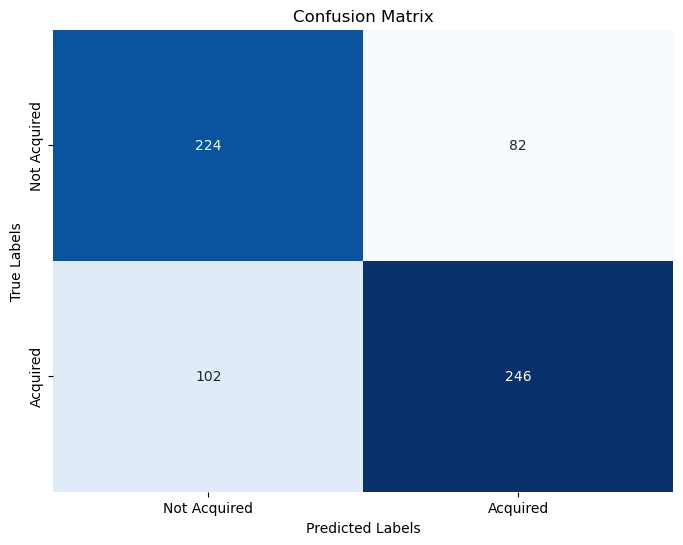


Classification Report:
Accuracy: 0.719
Precision: 0.750
Recall: 0.707
F1-Score: 0.728


In [6]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate confusion matrix
y_pred = ada_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Acquired', 'Acquired'], yticklabels=['Not Acquired', 'Acquired'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print individual metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print classification report
print("\nClassification Report:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
